# **Forecasting-Bus-Demand-in-Banana-Republic-Municipalities**

The central urban planning commitee of Banana Republic asked you to help them with the forecast of bus demands of municipalities. And they provide a nice dataset to support you (https://pi.works/3w8IJbV).

The dataset includes two measurements for an hour for the number of used buses in each municipality, each measurement is timestamped. The dataset format is as follows (comma separated values):

MUNICIPALITY_ID, TIMESTAMP, USAGE, TOTAL_CAPACITY

where municipality_id is an anonymization to disguise the actual names, timestamp represents the exact time of the measurement, usage is the number of buses in use at the time of measurement and total_capacity represents the total number of buses in the municipality. There are 10 municipalities (ids from 0 to 9), and two measurements for an hour.

The committee asks you to forecast the hourly bus usages for next week for each municipality. Hence you can aggregate the two measurements for an hour by taking the max value (sum would not be a nice idea for the obvious reasons) for each hour, and you should model this data with a time series model of your selection. (It would be a nice idea to implement a very simple baseline model first, and then try to improve the accuracy by introducing more complex methods eventually. The bare minimum requirement of the task is one simple baseline and one complex method.)

The committee says that they will use the last two weeks (starting from 2017-08-05 to 2017-08-19) as assessment (test) data, hence your code should report the error (in the criterion you chose for the task) for the last two weeks. You may use true values for the prediction of the last week of test data, then combine the error of the first and last week of the test separately.

Keep in mind that the dataset has missing data, hence a suitable missing data interpolation would be useful.

## Imports

In [1]:
import pandas as pd      
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA



import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (7,4)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

#To display the plots
%matplotlib inline
from ipywidgets import interact
import plotly.io as pio
import plotly.express as px
import cufflinks as cf
#Enabling the offline mode for interactive plotting locally
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## Get  the Data and and Make the Necessary Edits

In [2]:
df = pd.read_csv("municipality_bus_utilization.csv",index_col="timestamp",parse_dates=True)

In [3]:
df["date"] = df.index

In [4]:
df.index = df.index.strftime("%Y-%m-%d-%H")

In [5]:
df2=df.copy()  

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13070 entries, 2017-06-04-07 to 2017-08-19-16
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   municipality_id  13070 non-null  int64         
 1   usage            13070 non-null  int64         
 2   total_capacity   13070 non-null  int64         
 3   date             13070 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 510.5+ KB


In [7]:
df.head()

,municipality_id,usage,total_capacity,date
timestamp,,,,
2017-06-04-07,9,454,1332,2017-06-04 07:59:42
2017-06-04-07,8,556,2947,2017-06-04 07:59:42
2017-06-04-07,4,1090,3893,2017-06-04 07:59:42
2017-06-04-07,0,204,2813,2017-06-04 07:59:42
2017-06-04-07,7,718,2019,2017-06-04 07:59:42


In [8]:
df[(df.index < "2017-06-04-11") & (df.municipality_id == 1)]

,municipality_id,usage,total_capacity,date
timestamp,,,,
2017-06-04-07,1,129,397,2017-06-04 07:59:42
2017-06-04-08,1,138,397,2017-06-04 08:25:42
2017-06-04-08,1,164,397,2017-06-04 08:59:42
2017-06-04-09,1,213,397,2017-06-04 09:32:46
2017-06-04-09,1,245,397,2017-06-04 09:59:48
2017-06-04-10,1,273,397,2017-06-04 10:26:49
2017-06-04-10,1,317,397,2017-06-04 10:59:48


##### * New features' been created from data  by feature engineering
##### * The max value of the measurements made twice every hour was taken.

In [9]:
df = df.groupby([pd.Grouper(key="date",freq = "H"),"municipality_id"])["usage"].max().to_frame().reset_index().set_index("date")

In [10]:
df = df.sort_values(by=["municipality_id","date"])

In [11]:
df.head()

,municipality_id,usage
date,,
2017-06-04 07:00:00,0,204
2017-06-04 08:00:00,0,332
2017-06-04 09:00:00,0,485
2017-06-04 10:00:00,0,583
2017-06-04 11:00:00,0,614


In [12]:
df.municipality_id.value_counts().index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [17]:
def missingpart(municipality_id):
    missingindex = []
    for j in range(3,5):
        for i in range(10):
            missingindex.append(datetime(2017,8,j,i+7))
    missingindex = pd.Series(missingindex)
    missingpart = pd.DataFrame({"municipality_id" :municipality_id,"usage":[np.nan for i in range(20)],"date" : missingindex}).set_index("date")
    return missingpart

In [18]:
missingpart(0)

,municipality_id,usage
date,,
2017-08-03 07:00:00,0,NaN
2017-08-03 08:00:00,0,NaN
2017-08-03 09:00:00,0,NaN
2017-08-03 10:00:00,0,NaN
2017-08-03 11:00:00,0,NaN
2017-08-03 12:00:00,0,NaN
2017-08-03 13:00:00,0,NaN
2017-08-03 14:00:00,0,NaN
2017-08-03 15:00:00,0,NaN


In [116]:
#for i in range(10):
    #df = pd.concat([df,missingpart(i)])

In [19]:
df = pd.concat([df,missingpart(0),missingpart(1),missingpart(2),missingpart(3),missingpart(4),missingpart(5),missingpart(6),missingpart(7),missingpart(8),missingpart(9)])

In [20]:
df

,municipality_id,usage
date,,
2017-06-04 07:00:00,0,204.0
2017-06-04 08:00:00,0,332.0
2017-06-04 09:00:00,0,485.0
2017-06-04 10:00:00,0,583.0
2017-06-04 11:00:00,0,614.0
...,...,...
2017-08-04 12:00:00,9,NaN
2017-08-04 13:00:00,9,NaN
2017-08-04 14:00:00,9,NaN


In [21]:
df = df.sort_values(by=["municipality_id","date"])

In [22]:
df.isnull().sum()

municipality_id      0
usage              200
dtype: int64

In [23]:
df["usage"] = df["usage"].interpolate(method="linear")

In [24]:
df.isnull().sum()

municipality_id    0
usage              0
dtype: int64

In [25]:
df

,municipality_id,usage
date,,
2017-06-04 07:00:00,0,204.0
2017-06-04 08:00:00,0,332.0
2017-06-04 09:00:00,0,485.0
2017-06-04 10:00:00,0,583.0
2017-06-04 11:00:00,0,614.0
...,...,...
2017-08-19 12:00:00,9,849.0
2017-08-19 13:00:00,9,941.0
2017-08-19 14:00:00,9,983.0


##### * When we examine the data, we see that every municipality is skewed. We can use exponential smoothing.
##### * exponential smoothing places a bigger emphasis on more recent observations, providing a weighted average.

In [26]:
def column_histogram(col):
    fig = px.histogram(df,
                       x=col,
                       #nbins=80,
                        color="municipality_id")
    fig.show()
cols = df.columns

interact(column_histogram,col=cols);

interactive(children=(Dropdown(description='col', options=('municipality_id', 'usage'), value='municipality_id…

In [27]:
def column_boxer1(col):
    fig = px.box(df2,
                 
                 y= col)
    fig.show() 
cols = df2.columns    
interact(column_boxer1,col = cols);

interactive(children=(Dropdown(description='col', options=('municipality_id', 'usage', 'total_capacity', 'date…

In [28]:
for i in range(10):
    print("*"*50+"\n"+str(i)+". Municipality Bus Demand Before 2017-08-05\n"+"*"*50)
    print(df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == i)])

**************************************************
0. Municipality Bus Demand Before 2017-08-05
**************************************************
                     municipality_id       usage
date                                            
2017-06-04 07:00:00                0  204.000000
2017-06-04 08:00:00                0  332.000000
2017-06-04 09:00:00                0  485.000000
2017-06-04 10:00:00                0  583.000000
2017-06-04 11:00:00                0  614.000000
...                              ...         ...
2017-08-04 12:00:00                0  343.904762
2017-08-04 13:00:00                0  325.523810
2017-08-04 14:00:00                0  307.142857
2017-08-04 15:00:00                0  288.761905
2017-08-04 16:00:00                0  270.380952

[552 rows x 2 columns]
**************************************************
1. Municipality Bus Demand Before 2017-08-05
**************************************************
                     municipality_id       us

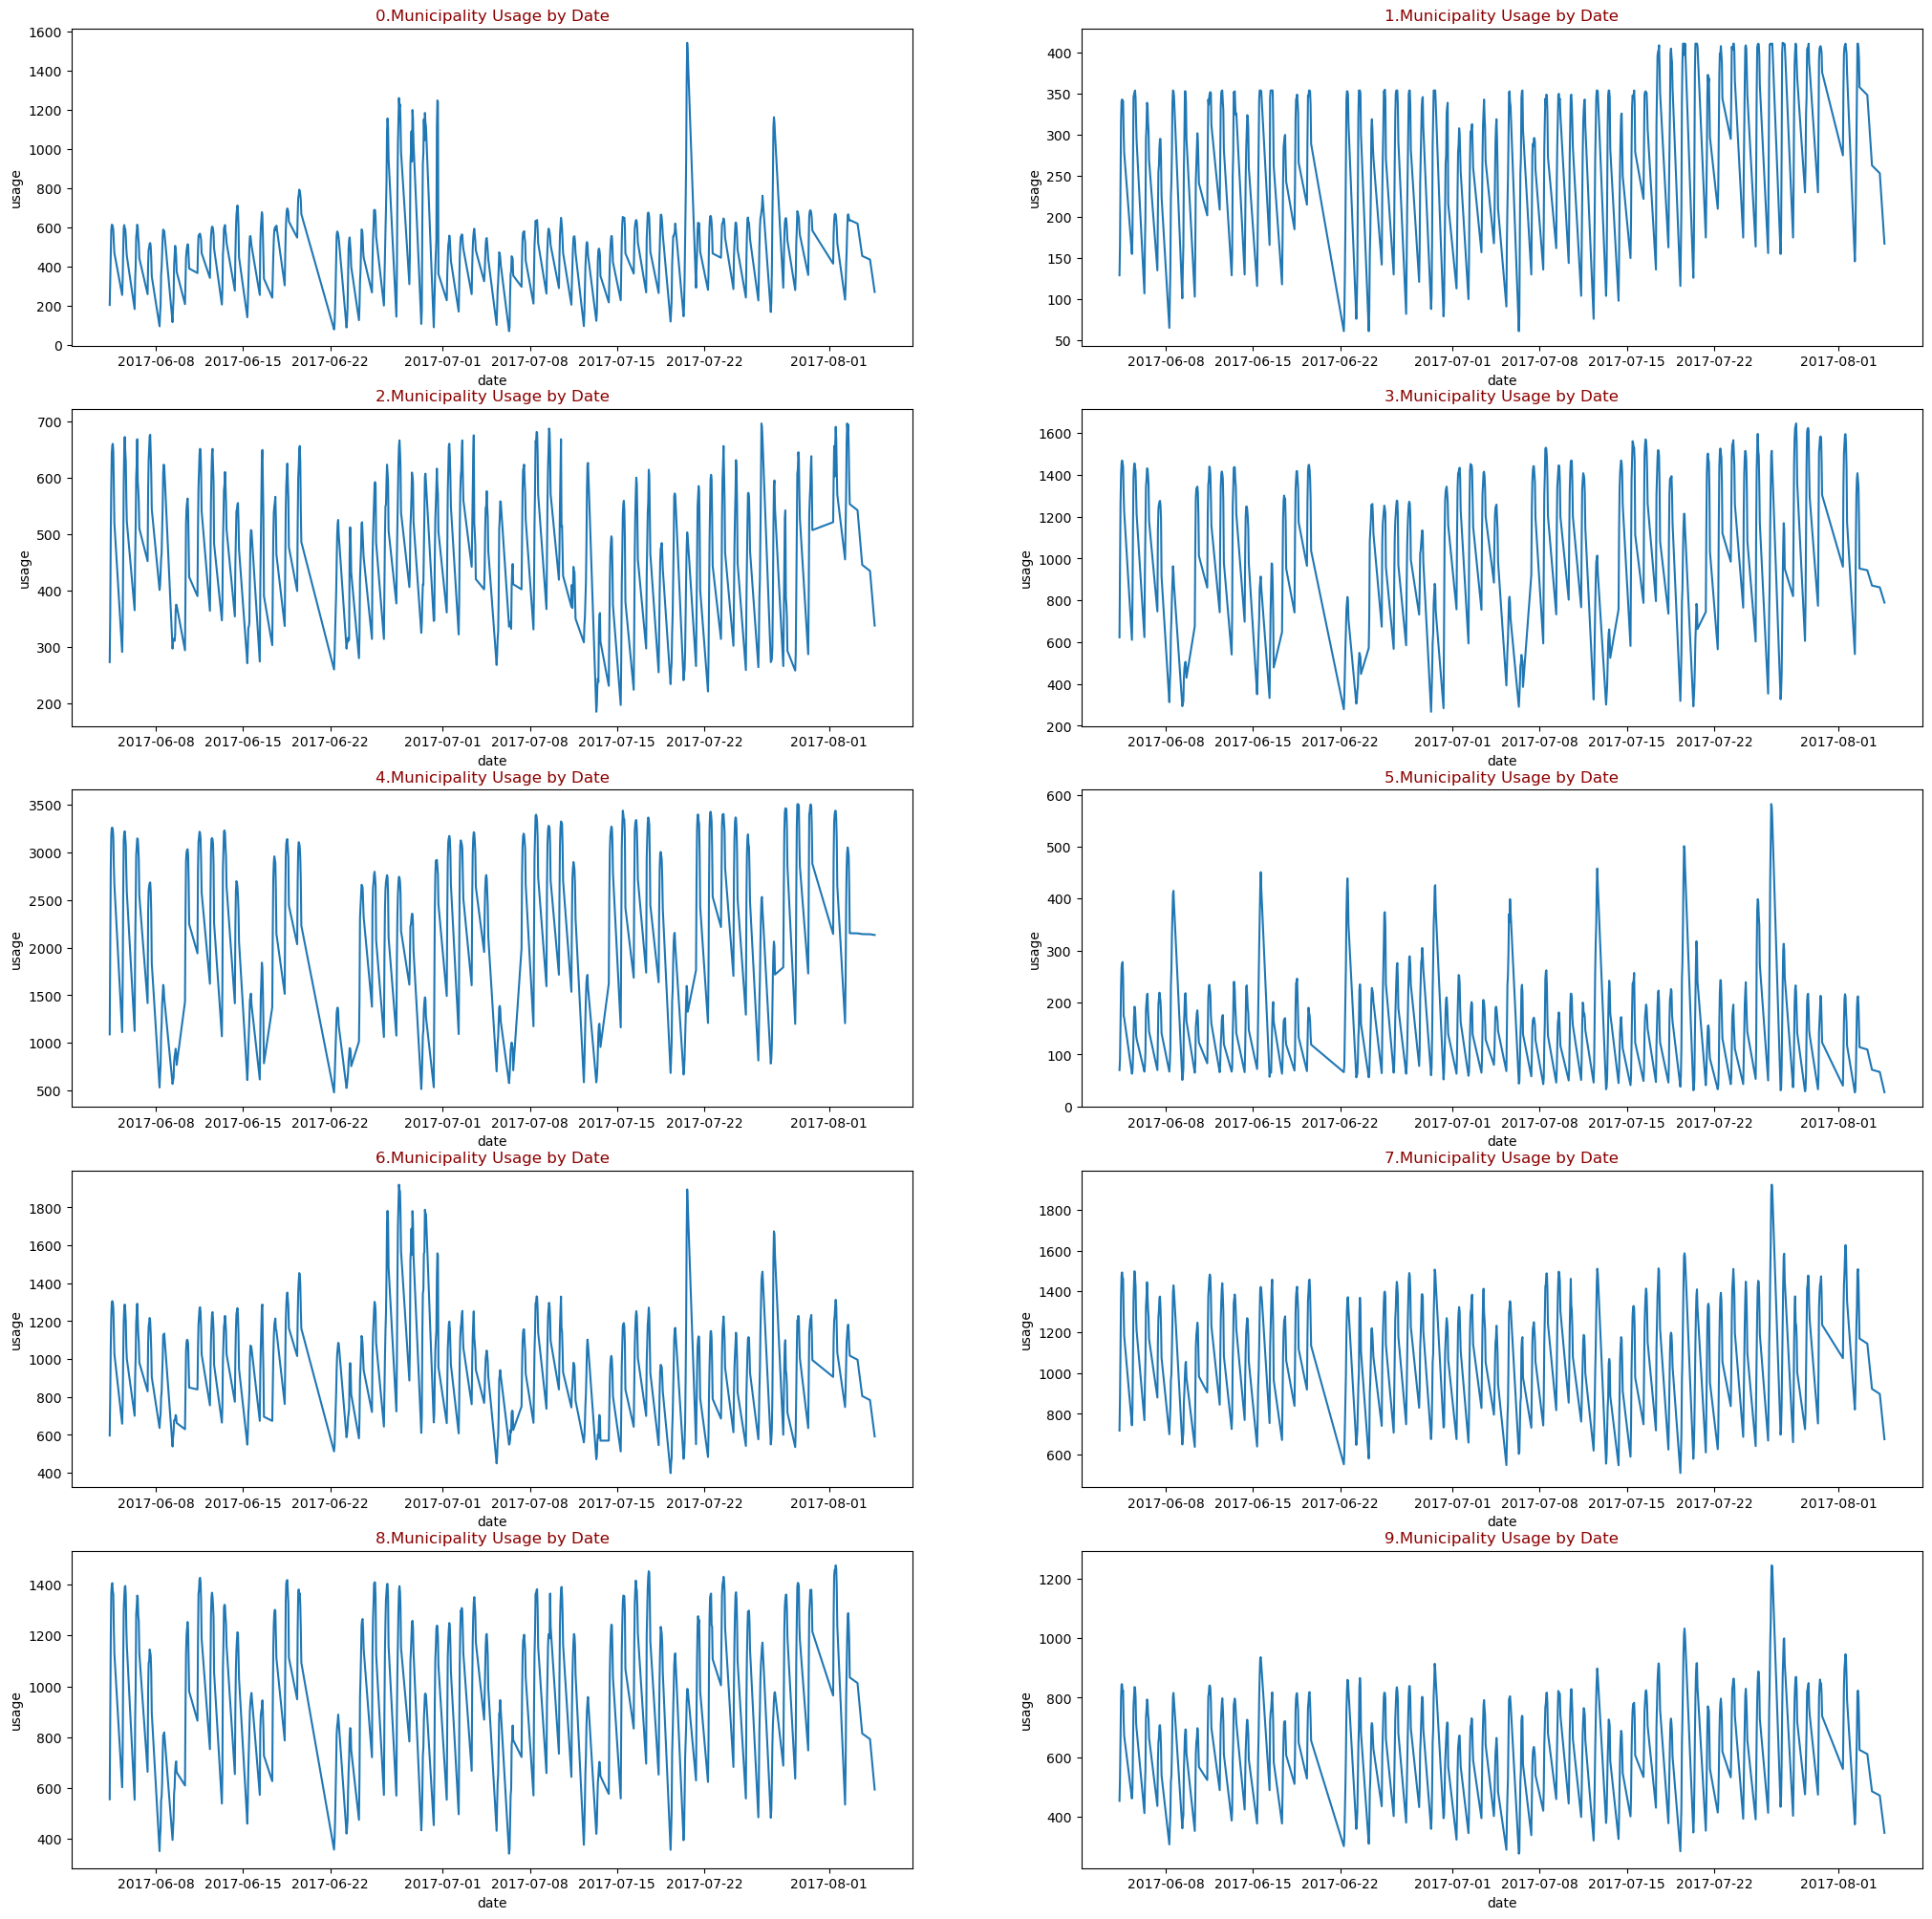

In [29]:
plt.figure(figsize = (25,25))
for i,j in zip(range(10),range(1,11)):
    plt.subplot(5,2,j)
    sns.lineplot(data = df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == i)],
                 x = df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == i)].index,
                y = df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == i)].usage)
    plt.title("{}.Municipality Usage by Date".format(i),color = "darkred")
   

### As seen above, it seems that there is no trend, seasonality and cyclicity, so we just need exponential smoothing
 

##

### Train and Test datasets 

##### *Since the variance values ​​of each municipality are different, we make separate modeling for each. Our goal in doing this is to increase accuracy.

In [30]:
df[(df.index >= datetime (year =2017,month = 8, day = 1)) & (df.municipality_id == 0)]

,municipality_id,usage
date,,
2017-08-01 08:00:00,0,415.000000
2017-08-01 09:00:00,0,564.000000
2017-08-01 10:00:00,0,634.000000
2017-08-01 11:00:00,0,666.000000
2017-08-01 12:00:00,0,669.000000
2017-08-01 13:00:00,0,664.000000
2017-08-01 14:00:00,0,639.000000
2017-08-01 15:00:00,0,597.000000
2017-08-01 16:00:00,0,519.000000


In [31]:
M0_train = df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 0)]
M0_test = df[(df.index >= datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 0)]
M1_train = df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 1)]
M1_test = df[(df.index >= datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 1)]
M2_train = df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 2)]
M2_test = df[(df.index >= datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 2)]
M3_train = df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 3)]
M3_test = df[(df.index >= datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 3)]
M4_train = df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 4)]
M4_test = df[(df.index >= datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 4)]
M5_train = df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 5)]
M5_test = df[(df.index >= datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 5)]
M6_train = df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 6)]
M6_test = df[(df.index >= datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 6)]
M7_train = df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 7)]
M7_test = df[(df.index >= datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 7)]
M8_train = df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 8)]
M8_test = df[(df.index >= datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 8)]
M9_train = df[(df.index < datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 9)]
M9_test = df[(df.index >= datetime (year =2017,month = 8, day = 5)) & (df.municipality_id == 9)]

##


##### * We  have to predict, or forecast, how much inventory we’ll want to use to match demand

##### * If our company allocates more vehicles than necessary, it will make an unnecessary investment, but if it allocates less vehicles, it cannot meet the need.

##### * Exponential smoothing is similar to simple moving averages in the sense that it estimates future values based on past observations, but there’s a critical difference: Simple moving averages consider past observations equally, whereas exponential smoothing assigns exponentially decreasing weights over time. This means that exponential smoothing places a bigger emphasis on more recent observations, providing a weighted average.

##### * 1)Single (or simple) exponential smoothing => no seasonality – no trend.

##### * 2)Double exponential smoothing => no seasonality – but with a trend.

##### * 3)Triple exponential smoothing =>  a trend and seasonal pattern.



### Created a "User defined function" to predict and visualize the demand by date

In [32]:
def prediction(Municipality_id,Municipality_train,Municipality_test):
    print("*"*50+"\nDemand by date for Municipality {}  is shown below".upper().format(Municipality_id),"\n"+"*"*50)
    model = ExponentialSmoothing(endog = Municipality_train.reset_index()["usage"],trend=None, seasonal=None, seasonal_periods=None).fit(optimized=True, use_boxcox=None, remove_bias=False)
    predict = pd.DataFrame(data = model.predict(start = 0 ,end = len(Municipality_test)-1).values,index = Municipality_test.index,columns=["usage"])
    RMSE = np.sqrt(mean_squared_error(Municipality_test["usage"] , predict.values))
    print("RMSE: ",RMSE)
    print("RMSE/Demand mean ratio:",round(RMSE/Municipality_test["usage"].mean(),2))
    plt.figure(dpi = 120)
    sns.lineplot(x = Municipality_train.index ,y = Municipality_train.usage)
    plt.title("Train",color="blue",loc = "left")
    sns.lineplot(x = predict.index ,y = predict.usage)
    plt.title("Predict",color="orange",loc = "center")
    sns.lineplot(x = Municipality_test.index ,y = Municipality_test.usage)
    plt.title("Test",color="green",loc = "right")
    return (pd.DataFrame(data = predict.usage.apply(lambda x : round(x)).values,index = predict.index,columns = ["Supply"]).T)


##

# Predictions and Visualising Forecast

## Municipality "0"

**************************************************
DEMAND BY DATE FOR MUNICIPALITY 0  IS SHOWN BELOW 
**************************************************
RMSE:  340.97721505681676
RMSE/Demand mean ratio: 0.5


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,359,205,331,484,583,614,613,605,585,520,470,256,335,486,594,612,595,592,556,491,454,184,332,398,548,578,614,601,550,518,443,260,412,486,499,518,520,503,443,350,96,158,204,357,397,466,551,589,584,582,118,185,239,403,456,506,489,453,373,209,323,444,480,500,514,511,448,390,367,484,558,555,567,568,555,536,469,343,469,550,585,604,603,591,566,492,207,285,460,505,597,600,612,577,563,521,278,461,582,662,690,712,684,608,449,143,212,310,416,506,554,556,535,508,256,520,601,639,678,666,552,459,339,241,351,452,538,586,597,603,585,609,306,457,579,649,687,697,691,679,630,548


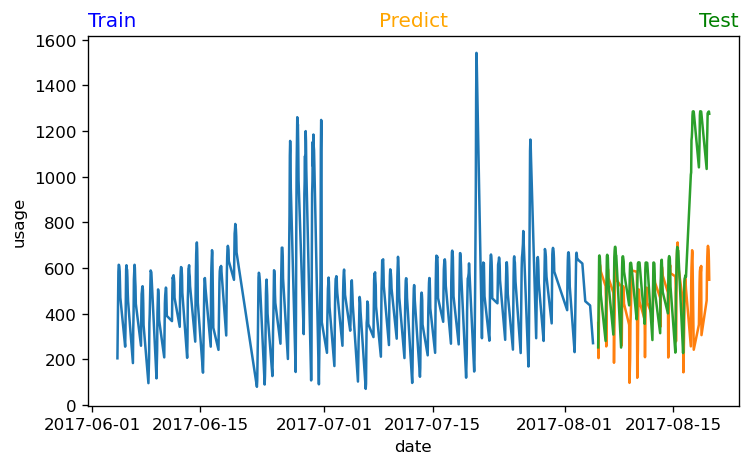

In [33]:
prediction(0,M0_train,M0_test)

## Municipality "1"

**************************************************
DEMAND BY DATE FOR MUNICIPALITY 1  IS SHOWN BELOW 
**************************************************
RMSE:  120.3578552938148
RMSE/Demand mean ratio: 0.35


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,184,129,164,245,317,341,343,342,341,303,279,156,178,265,346,349,352,354,345,315,293,108,166,201,296,309,339,337,316,305,269,136,208,255,263,285,295,295,269,225,66,101,137,225,242,279,339,354,353,347,102,138,165,256,298,353,353,341,295,104,162,244,264,280,302,293,266,241,202,285,343,337,347,351,352,351,312,210,274,334,351,354,354,340,330,282,130,155,250,278,352,351,353,334,324,326,131,193,246,282,304,324,323,308,260,117,176,239,299,344,354,354,354,353,167,344,354,354,354,354,354,315,262,119,171,242,285,292,298,300,268,243,185,240,318,343,345,349,341,327,266,215


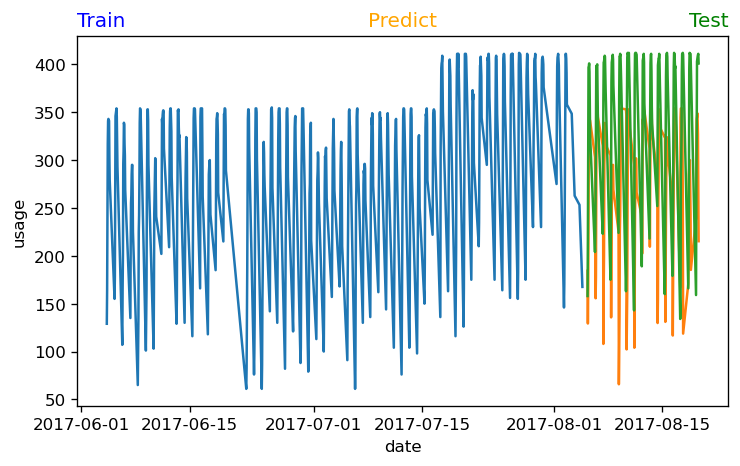

In [34]:
prediction(1,M1_train,M1_test)

## Municipality "2"

**************************************************
DEMAND BY DATE FOR MUNICIPALITY 2  IS SHOWN BELOW 
**************************************************
RMSE:  132.62932063247882
RMSE/Demand mean ratio: 0.25


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,381,274,355,493,582,643,657,660,646,581,520,292,339,472,586,649,672,647,629,564,522,366,456,514,600,623,668,594,579,556,510,452,577,631,652,674,676,645,607,544,402,409,430,455,466,506,548,609,623,621,299,309,312,315,311,322,364,375,373,294,416,519,546,556,563,541,480,424,390,509,583,611,642,651,647,610,541,365,448,556,609,642,651,621,592,484,348,378,482,525,577,587,610,586,557,508,355,448,498,540,544,553,555,523,473,272,299,334,336,344,425,489,507,506,275,408,480,557,633,649,592,529,391,303,395,494,538,549,556,566,529,464,338,437,543,587,605,625,594,563,477,399


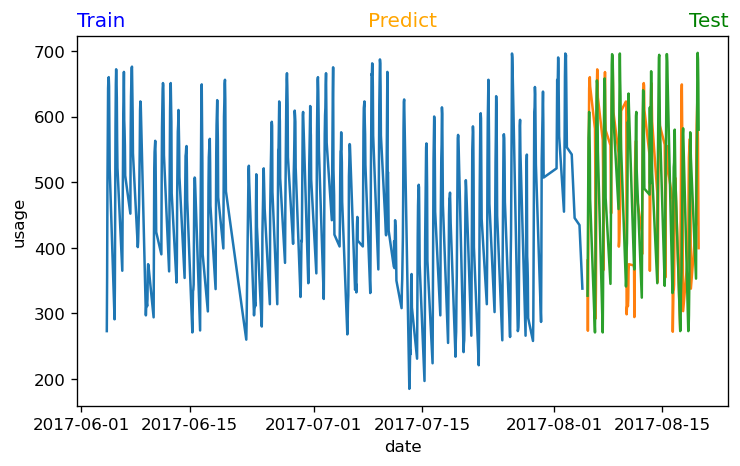

In [35]:
prediction(2,M2_train,M2_test)

## Municipality "3"

**************************************************
DEMAND BY DATE FOR MUNICIPALITY 3  IS SHOWN BELOW 
**************************************************
RMSE:  402.21667328066627
RMSE/Demand mean ratio: 0.35


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,964,625,965,1262,1395,1456,1469,1457,1439,1310,1227,614,787,1145,1387,1439,1455,1436,1418,1313,1213,627,944,1127,1343,1375,1431,1430,1397,1355,1180,749,1132,1237,1259,1271,1276,1254,1189,916,316,406,464,634,710,813,884,963,933,874,297,306,317,425,474,496,506,487,430,675,1056,1289,1333,1340,1344,1316,1207,1013,862,1217,1351,1378,1440,1434,1403,1300,1159,745,1104,1341,1401,1416,1406,1383,1273,982,543,735,1246,1331,1433,1437,1437,1375,1344,1214,701,1017,1200,1248,1249,1234,1200,1143,979,354,446,560,638,717,856,889,914,862,336,528,751,868,976,974,880,724,480,647,947,1190,1276,1301,1287,1286,1184,953,743,1099,1326,1379,1418,1418,1381,1338,1174,966


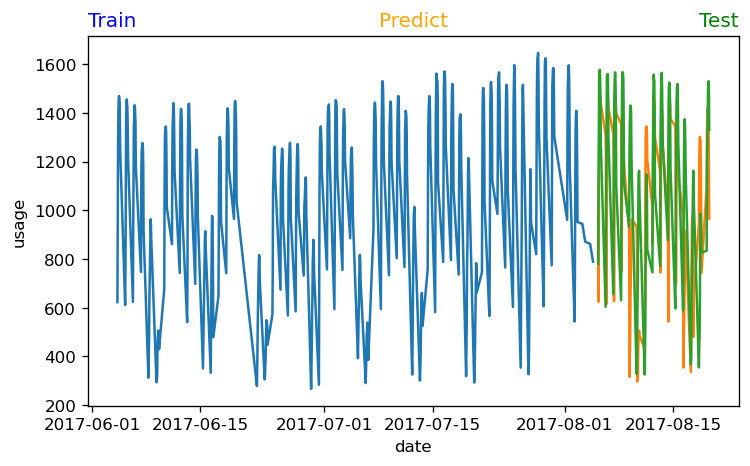

In [36]:
prediction(3,M3_train,M3_test)

## Municipality "4"

**************************************************
DEMAND BY DATE FOR MUNICIPALITY 4  IS SHOWN BELOW 
**************************************************
RMSE:  976.2654106591327
RMSE/Demand mean ratio: 0.38


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,2022,1095,2011,2807,3176,3257,3260,3241,3154,2850,2666,1121,1606,2556,3123,3203,3222,3155,3081,2792,2581,1133,1979,2424,2963,3052,3146,3143,3064,2931,2553,1424,2375,2599,2647,2678,2685,2591,2365,1842,540,670,771,1076,1198,1404,1509,1609,1586,1474,575,604,635,795,859,892,939,898,771,1430,2362,2909,3001,3023,3033,2976,2695,2249,1943,2823,3105,3164,3217,3206,3138,2921,2583,1626,2489,3001,3139,3150,3138,3093,2872,2260,1076,1597,2812,3025,3218,3231,3205,3065,2955,2644,1422,2209,2592,2697,2684,2638,2541,2392,2068,618,745,951,1095,1257,1449,1481,1518,1409,621,1111,1505,1655,1842,1790,1533,1210,789,1371,2161,2727,2892,2958,2926,2890,2610,2149,1518,2440,2950,3090,3125,3140,3052,2957,2445,2038


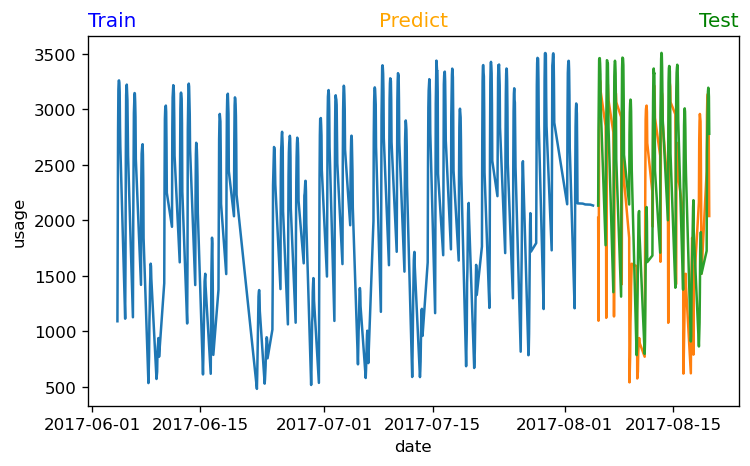

In [37]:
prediction(4,M4_train,M4_test)

## Municipality "5"

**************************************************
DEMAND BY DATE FOR MUNICIPALITY 5  IS SHOWN BELOW 
**************************************************
RMSE:  123.49870612357421
RMSE/Demand mean ratio: 0.72


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,126,70,89,159,228,268,275,278,247,174,171,64,68,92,137,171,192,188,167,138,130,67,79,104,186,200,215,217,184,167,144,70,137,197,208,219,210,202,181,141,67,84,113,231,263,329,366,409,415,390,53,59,73,157,179,214,218,200,164,65,82,153,168,180,185,170,139,123,83,138,209,228,234,226,217,176,159,66,82,121,137,167,173,176,149,120,67,74,136,175,239,240,223,190,171,141,66,109,166,229,233,214,191,180,147,72,110,180,248,306,361,418,451,421,59,66,66,65,114,155,189,201,163,64,85,128,162,168,166,170,130,119,69,100,187,237,240,246,209,174,133,68


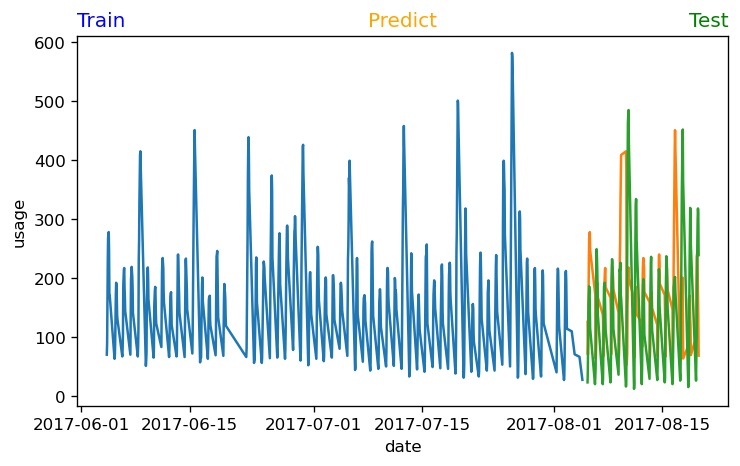

In [38]:
prediction(5,M5_train,M5_test)

## Municipality "6"

**************************************************
DEMAND BY DATE FOR MUNICIPALITY 0  IS SHOWN BELOW 
**************************************************
RMSE:  323.85314103937264
RMSE/Demand mean ratio: 0.29


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,851,598,800,1060,1218,1297,1306,1297,1271,1137,1029,661,768,1011,1190,1268,1288,1257,1201,1066,1001,703,904,1007,1192,1238,1292,1205,1133,1090,983,831,1084,1171,1192,1217,1199,1134,1048,906,638,683,711,797,827,907,1000,1126,1127,1135,542,586,612,677,677,686,705,698,663,630,854,1043,1090,1102,1100,1081,966,851,840,1050,1182,1226,1268,1274,1247,1164,1027,757,934,1095,1176,1235,1248,1211,1149,971,667,751,991,1082,1170,1192,1228,1195,1150,1027,776,1012,1149,1237,1253,1269,1232,1134,950,551,610,712,765,835,1005,1071,1069,1058,676,929,1072,1172,1277,1288,1075,940,697,674,861,1016,1114,1181,1200,1214,1157,1151,765,992,1193,1283,1332,1351,1318,1278,1164,1017


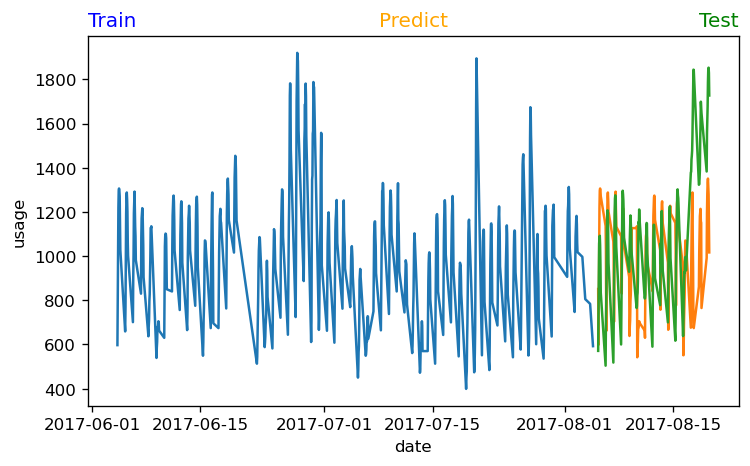

In [39]:
prediction(0,M6_train,M6_test)

## Municipality "7"

**************************************************
DEMAND BY DATE FOR MUNICIPALITY 7  IS SHOWN BELOW 
**************************************************
RMSE:  320.47765785265454
RMSE/Demand mean ratio: 0.26


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,949,719,872,1150,1372,1478,1493,1470,1461,1298,1185,746,826,1098,1347,1445,1499,1471,1423,1273,1207,771,948,1063,1323,1372,1445,1373,1315,1277,1167,881,1155,1273,1309,1370,1375,1320,1231,1076,702,766,831,963,996,1112,1265,1396,1430,1402,654,682,709,855,912,987,1045,1055,977,640,869,1120,1187,1213,1247,1223,1100,984,905,1187,1377,1417,1468,1483,1471,1389,1231,847,1032,1258,1347,1413,1440,1378,1303,1085,728,791,1060,1173,1342,1364,1385,1362,1297,1214,772,963,1110,1202,1242,1269,1256,1193,1058,642,768,927,1009,1131,1293,1409,1422,1411,758,1118,1216,1310,1416,1458,1359,1233,966,673,861,1079,1198,1256,1268,1278,1184,1063,840,1040,1290,1377,1406,1423,1367,1310,1118,920


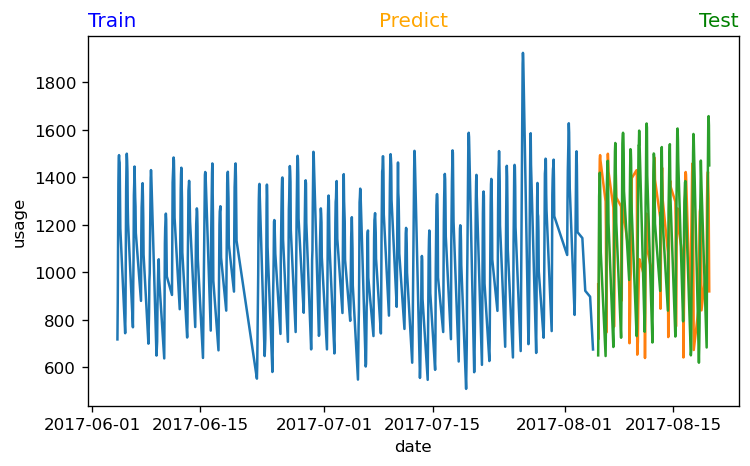

In [40]:
prediction(7,M7_train,M7_test)

## Municipality "8"

**************************************************
DEMAND BY DATE FOR MUNICIPALITY 8  IS SHOWN BELOW 
**************************************************
RMSE:  333.1265587085404
RMSE/Demand mean ratio: 0.32


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,894,558,856,1170,1362,1399,1406,1376,1361,1223,1130,606,744,1090,1296,1349,1390,1395,1359,1233,1161,557,865,991,1280,1312,1357,1349,1280,1255,1133,666,986,1091,1099,1145,1133,1121,1051,896,355,411,442,551,567,620,728,808,811,819,398,439,481,580,602,667,694,705,662,610,916,1128,1202,1230,1253,1223,1111,981,866,1177,1363,1381,1422,1427,1407,1336,1189,755,1049,1279,1350,1368,1353,1319,1269,1056,542,662,1072,1161,1309,1321,1318,1276,1246,1161,658,918,1066,1142,1183,1213,1207,1131,1032,463,554,678,759,826,907,939,961,974,575,831,888,905,915,945,901,831,728,628,925,1146,1243,1290,1301,1297,1205,1111,789,1086,1334,1406,1415,1418,1372,1328,1114,950


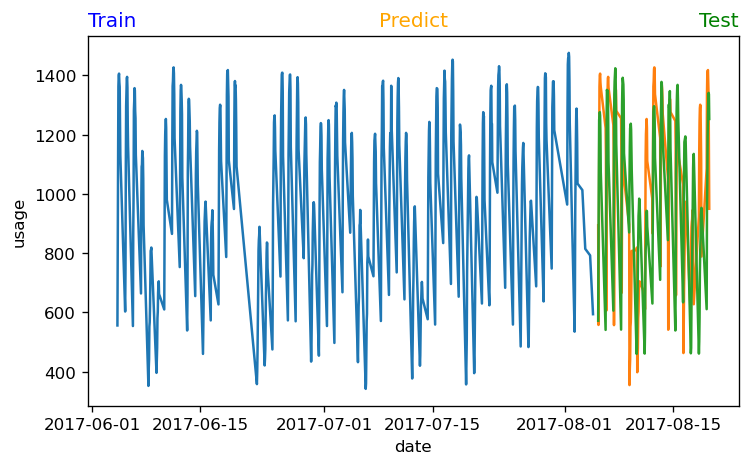

In [41]:
prediction(8,M8_train,M8_test)

## Municipality "9"

**************************************************
DEMAND BY DATE FOR MUNICIPALITY 9  IS SHOWN BELOW 
**************************************************
RMSE:  208.3094755381753
RMSE/Demand mean ratio: 0.29


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,578,455,527,665,799,845,845,820,824,725,673,463,496,634,769,805,836,833,803,717,694,414,502,559,732,758,794,790,745,730,665,438,586,652,666,706,708,684,633,540,309,366,410,517,539,616,726,804,816,790,364,390,406,553,610,674,694,691,613,354,461,609,650,666,698,691,628,568,524,686,803,815,840,841,833,788,698,491,593,710,747,780,798,766,720,611,389,422,586,658,774,786,797,785,749,715,426,525,622,671,712,726,710,679,593,379,479,602,682,796,878,930,936,914,492,719,749,762,793,818,776,712,585,379,476,594,670,717,721,721,664,607,511,611,755,799,814,815,782,756,650,530


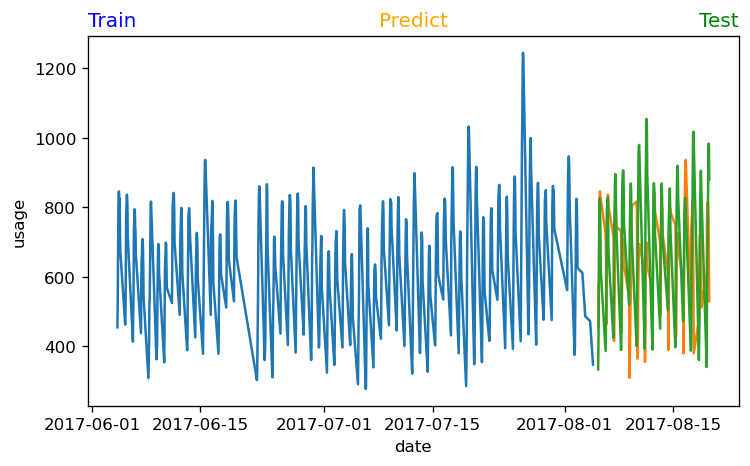

In [42]:
prediction(9,M9_train,M9_test)

# ARIMA Model 

##### *The term “autoregressive” in ARMA means that the model uses past values to predict future ones. weights
 autocorrelation is the similarity between observations as a function of the time lag between them.
 
 Seasonality refers to periodic fluctuations
Stationarity has constant mean and variance, and covariance is independent of time.

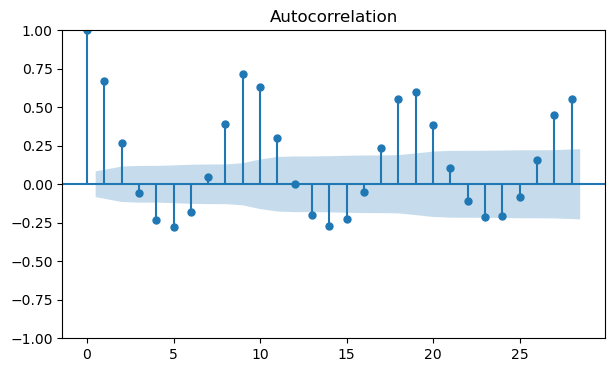

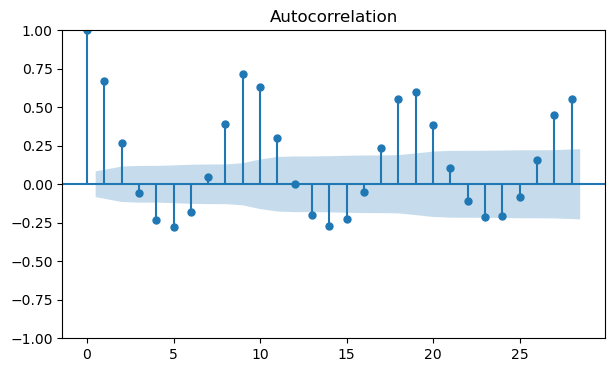

In [43]:
plot_acf(M1_train.usage)             

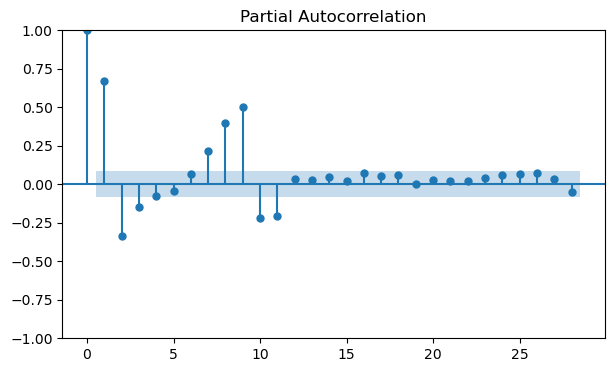

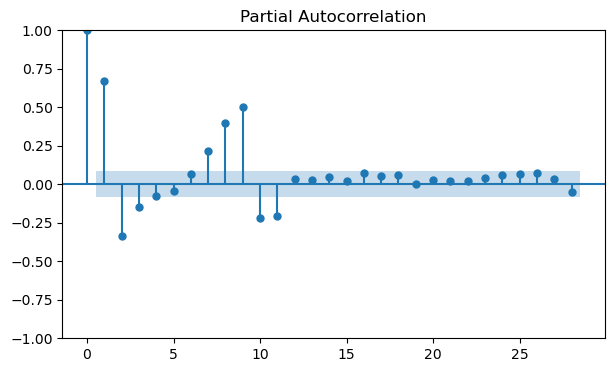

In [44]:
plot_pacf(M1_train.usage)

In [45]:
def best_pq_finder(Municipality_train,Municipality_test):
        large = 5000
        for p in range(1,11):
            for q in range(1,12):
                modelArima = ARIMA(endog  = Municipality_train.reset_index()["usage"] , order=(p,0,q),enforce_stationarity=False).fit()
                predict = pd.DataFrame(data = modelArima.predict(start = 0,end = 141).values,index = Municipality_test.index , columns=["usage"])
                rmse = np.sqrt(mean_squared_error(Municipality_test.usage.values,predict.values))
                if rmse < large : 
                    large = rmse
                    result = rmse,p,q
        print("RMSE:",result[0])
        plt.figure(dpi = 120)
        sns.lineplot(x = Municipality_train.index ,y = Municipality_train.usage)
        plt.title("Train",color="blue",loc = "left")
        sns.lineplot(x = predict.index ,y = predict.usage)
        plt.title("Predict\nARIMA({},0,{})".format(result[1],result[2]),color="orange",loc = "center")
        sns.lineplot(x = Municipality_test.index ,y = Municipality_test.usage)
        plt.title("Test",color="green",loc = "right")
        return (pd.DataFrame(data = predict.usage.apply(lambda x : round(x)).values,index = predict.index,columns = ["Supply"]).T)
        

RMSE: 328.60358907235025


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,529,377,557,529,596,545,579,517,589,355,363,359,542,565,611,600,585,545,531,375,372,319,481,524,545,595,585,557,522,354,398,366,511,580,511,544,512,506,433,250,188,328,341,441,478,484,529,539,418,454,177,276,387,438,542,551,527,481,188,169,417,513,520,530,534,483,439,334,336,507,576,577,579,560,502,476,447,386,508,569,588,614,593,565,505,403,282,404,535,538,610,615,589,537,393,444,396,500,645,649,658,669,649,553,283,214,409,443,506,594,587,535,499,357,200,535,658,630,674,648,516,442,269,317,464,501,629,636,552,535,510,484,305,499,642,631,682,691,633,621,463,497


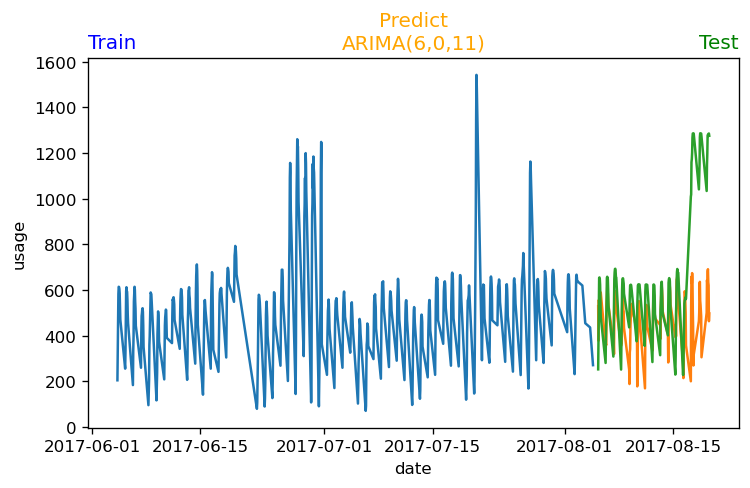

In [46]:
best_pq_finder(M0_train,M0_test)

RMSE: 99.19792427465333


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,291,113,238,266,335,321,340,323,333,182,263,167,271,312,351,344,349,325,305,220,231,197,259,270,311,333,336,325,297,189,224,196,272,299,297,314,294,297,259,156,126,194,212,268,285,303,325,307,217,250,150,198,217,271,339,355,353,332,160,90,182,283,306,322,331,311,267,135,170,305,338,328,337,335,311,290,243,234,309,331,341,345,343,335,301,214,176,242,300,311,353,350,346,309,211,250,215,244,307,316,325,319,320,315,165,137,238,286,322,348,353,339,308,224,163,324,361,362,352,340,346,312,164,199,262,281,314,319,330,305,258,166,182,284,340,341,333,337,310,281,211,218


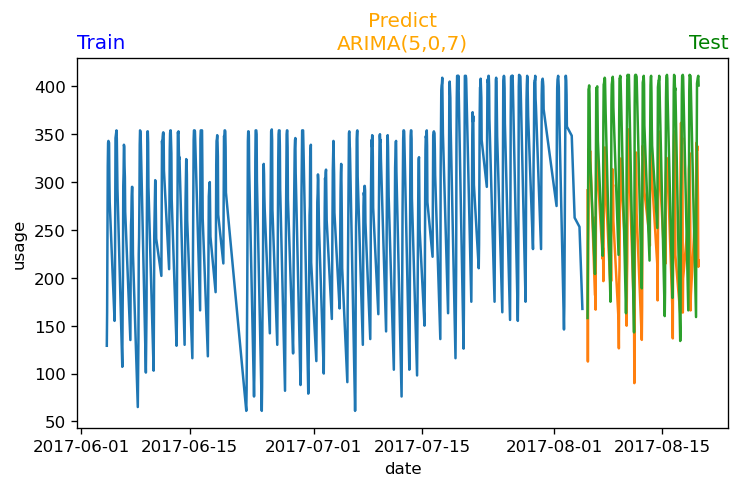

In [47]:
best_pq_finder(M1_train,M1_test)

RMSE: 109.15206998256552


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,487,168,476,491,603,650,676,655,648,427,545,261,480,510,584,643,672,587,553,403,457,431,520,534,606,622,638,533,510,443,505,480,584,616,643,615,603,582,527,468,437,458,466,505,513,527,552,582,526,554,294,316,337,382,388,401,448,438,286,297,442,511,505,493,516,488,429,337,393,574,609,592,607,621,595,538,477,405,529,617,642,649,654,614,550,390,374,478,561,572,594,588,595,518,439,455,399,477,509,539,545,533,523,469,376,303,364,393,390,401,478,512,495,396,254,433,478,524,599,622,556,478,262,324,479,574,594,571,566,553,469,393,367,530,604,594,588,612,570,504,384,416


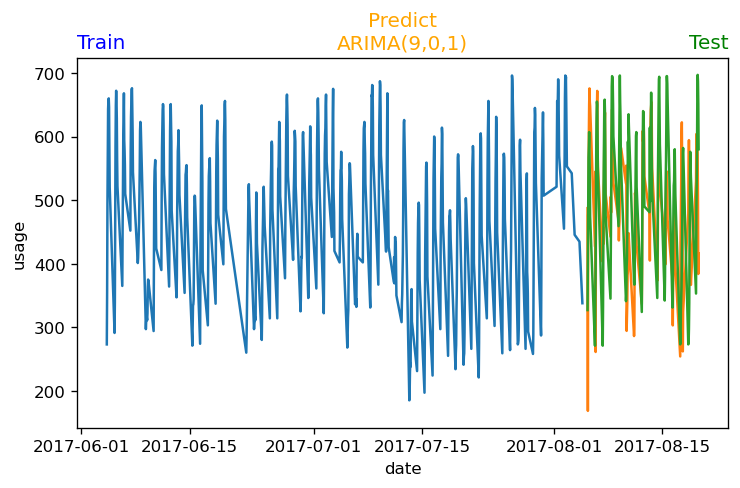

In [48]:
best_pq_finder(M2_train,M2_test)

RMSE: 327.204987978412


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,1078,458,1203,1243,1452,1430,1474,1434,1415,951,1391,563,1062,1175,1406,1407,1412,1332,1307,882,1085,826,1097,1223,1357,1362,1352,1331,1262,1017,1110,866,1228,1292,1266,1256,1213,1221,1083,672,421,642,640,753,808,894,983,925,603,759,411,437,473,601,674,657,624,597,357,656,1089,1321,1337,1297,1306,1252,1053,939,1044,1466,1487,1398,1432,1433,1363,1144,984,917,1324,1406,1400,1409,1379,1329,1155,707,623,1007,1368,1351,1397,1402,1385,1191,922,1056,975,1167,1248,1275,1265,1169,1128,1065,748,448,669,732,769,806,899,962,939,563,270,680,871,929,1047,1035,981,791,232,612,1178,1325,1321,1315,1302,1220,928,781,908,1384,1470,1391,1400,1411,1326,1132,937,1082


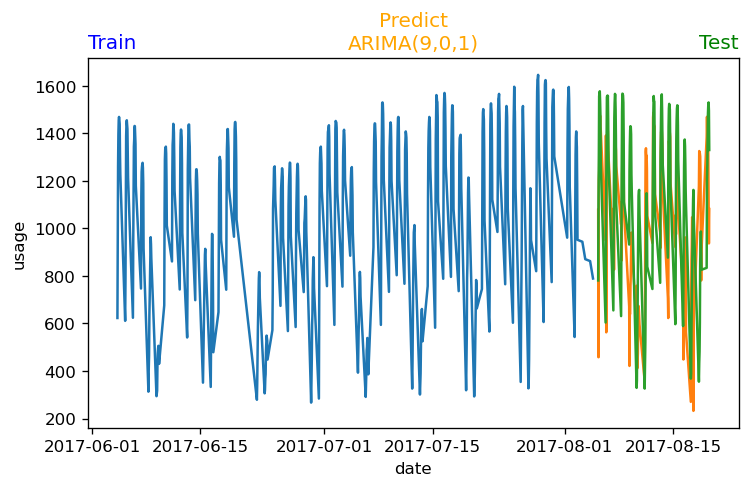

In [49]:
best_pq_finder(M3_train,M3_test)

RMSE: 804.3464379697305


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,2301,640,2584,2815,3289,3175,3261,3145,3086,1902,3039,1141,2240,2665,3147,3136,3101,2883,2859,1778,2270,1653,2409,2674,2978,2991,2932,2862,2792,2144,2386,1771,2644,2767,2652,2624,2536,2511,2196,1239,733,1231,1136,1277,1399,1599,1710,1619,954,1284,878,874,926,1159,1254,1162,1116,1104,750,1447,2449,3010,3063,2994,3015,2884,2331,2068,2371,3394,3411,3193,3201,3212,3005,2501,2137,2038,3012,3143,3087,3107,3068,2934,2594,1587,1224,2187,3044,3021,3116,3159,3127,2734,1911,2182,2095,2603,2705,2763,2722,2466,2300,2188,1513,819,1258,1331,1363,1417,1515,1622,1691,840,456,1433,1760,1792,1985,1972,1782,1355,343,1361,2664,2958,2975,3056,2998,2704,1961,1779,2004,3111,3271,3167,3157,3104,2843,2501,1877,2297


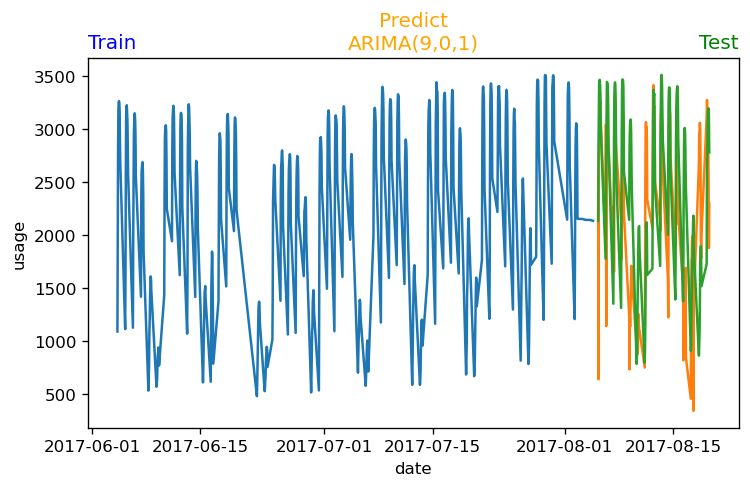

In [50]:
best_pq_finder(M4_train,M4_test)

RMSE: 102.25189814407581


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,175,98,126,196,233,226,247,215,209,85,131,101,133,172,194,183,216,148,172,89,120,103,114,172,204,226,184,198,165,124,138,88,194,220,218,215,182,187,150,108,85,144,149,246,270,301,329,325,318,301,29,71,113,187,222,236,258,188,35,39,147,207,192,187,211,172,135,73,74,172,235,256,233,216,181,151,122,72,125,152,176,190,192,169,135,85,69,123,166,212,246,242,199,155,129,119,99,138,219,245,228,193,172,157,94,86,154,235,261,284,328,360,372,293,9,57,114,118,168,207,250,210,27,47,139,146,191,193,209,178,128,72,61,130,216,269,232,247,179,149,93,55


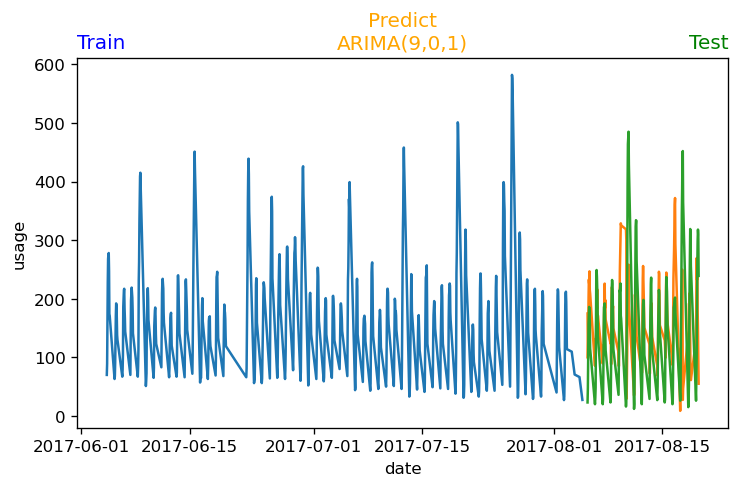

In [51]:
best_pq_finder(M5_train,M5_test)  

RMSE: 302.05350275148703


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,1014,340,1176,984,1306,1269,1295,1248,1321,806,1067,581,1101,1117,1176,1252,1262,1155,1115,845,852,841,1099,1107,1180,1241,1237,1119,1060,884,932,939,1199,1217,1178,1185,1128,1102,987,788,752,865,845,904,930,949,994,1072,945,989,563,645,711,764,831,850,855,805,481,610,951,1056,1021,1013,1025,980,920,833,880,1153,1257,1223,1227,1226,1143,1038,979,859,1043,1183,1226,1245,1226,1166,1044,795,717,924,1099,1140,1195,1174,1166,1087,926,921,886,1096,1191,1222,1245,1223,1190,1045,768,642,832,895,883,954,1078,1064,997,829,578,953,1105,1121,1265,1259,1023,918,591,750,1043,1146,1214,1198,1099,1077,1003,1039,785,1046,1264,1272,1308,1314,1243,1189,938,1011


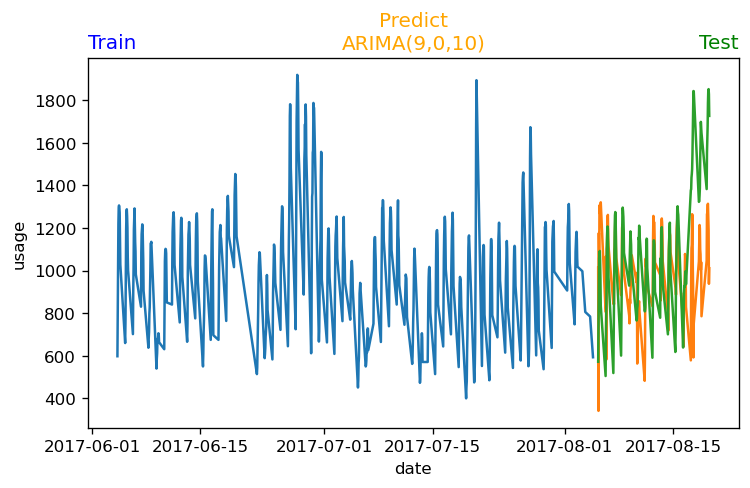

In [52]:
best_pq_finder(M6_train,M6_test)

RMSE: 266.4094996547143


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,1141,491,1110,1198,1431,1477,1499,1436,1470,961,1234,672,1127,1242,1350,1402,1472,1345,1257,948,1013,934,1151,1200,1337,1387,1399,1289,1200,941,1064,989,1266,1313,1299,1318,1282,1275,1126,851,840,968,995,1103,1132,1179,1248,1279,1116,1172,705,744,792,969,1135,1183,1233,1145,654,628,970,1218,1193,1176,1224,1174,1039,802,935,1322,1431,1393,1399,1381,1304,1211,1105,981,1183,1354,1415,1446,1437,1347,1183,852,816,1039,1222,1283,1384,1354,1313,1189,980,1045,917,1055,1208,1234,1275,1266,1250,1136,784,728,970,1086,1113,1196,1309,1346,1272,1052,701,1102,1234,1291,1419,1441,1351,1188,669,815,1079,1242,1343,1333,1269,1196,1041,866,859,1167,1361,1355,1341,1346,1250,1145,927,957


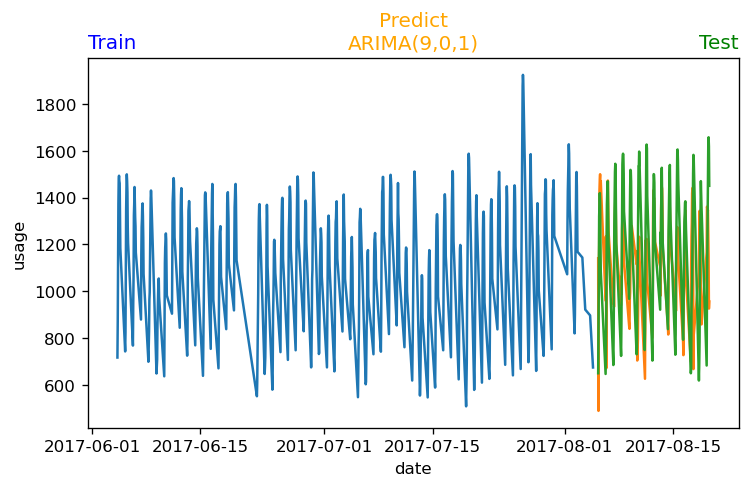

In [53]:
best_pq_finder(M7_train,M7_test)

RMSE: 244.97173221063326


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,1029,340,1126,1164,1451,1356,1458,1301,1398,822,1280,560,1055,1132,1272,1301,1368,1258,1224,851,940,844,1025,1071,1254,1325,1284,1232,1193,835,991,830,1083,1162,1128,1163,1054,1091,999,616,512,646,611,679,700,759,821,838,547,661,542,565,582,655,764,799,820,847,581,609,930,1162,1225,1249,1278,1212,1050,872,990,1361,1492,1462,1465,1445,1340,1192,1035,976,1274,1376,1396,1390,1355,1300,1185,782,649,920,1178,1220,1291,1307,1285,1141,793,884,922,1037,1136,1172,1182,1131,1131,1084,723,558,745,809,856,908,987,983,974,651,494,862,950,955,971,1004,961,883,544,675,1045,1189,1243,1278,1278,1190,1039,902,898,1244,1418,1434,1409,1389,1298,1204,871,972


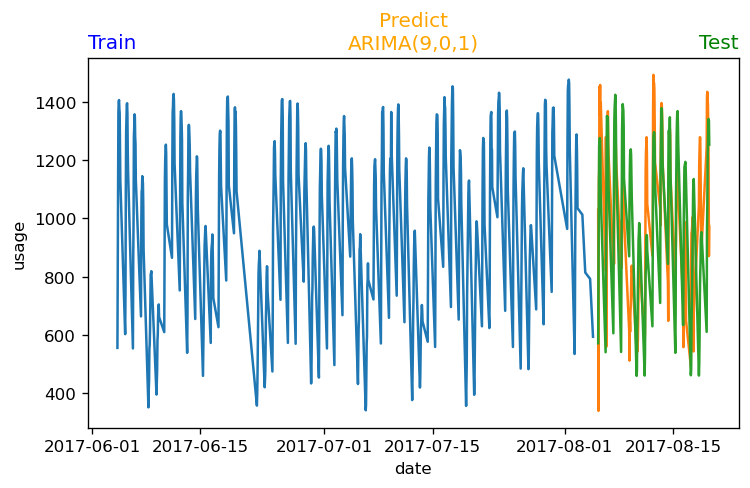

In [54]:
best_pq_finder(M8_train,M8_test)

RMSE: 175.4455416939749


date,2017-08-05 08:00:00,2017-08-05 09:00:00,2017-08-05 10:00:00,2017-08-05 11:00:00,2017-08-05 12:00:00,2017-08-05 13:00:00,2017-08-05 14:00:00,2017-08-05 15:00:00,2017-08-05 16:00:00,2017-08-06 07:00:00,2017-08-06 08:00:00,2017-08-06 09:00:00,2017-08-06 10:00:00,2017-08-06 11:00:00,2017-08-06 12:00:00,2017-08-06 13:00:00,2017-08-06 14:00:00,2017-08-06 15:00:00,2017-08-06 16:00:00,2017-08-07 07:00:00,2017-08-07 08:00:00,2017-08-07 09:00:00,2017-08-07 10:00:00,2017-08-07 11:00:00,2017-08-07 12:00:00,2017-08-07 13:00:00,2017-08-07 14:00:00,2017-08-07 15:00:00,2017-08-07 16:00:00,2017-08-08 07:00:00,2017-08-08 08:00:00,2017-08-08 09:00:00,2017-08-08 10:00:00,2017-08-08 11:00:00,2017-08-08 12:00:00,2017-08-08 13:00:00,2017-08-08 14:00:00,2017-08-08 15:00:00,2017-08-08 16:00:00,2017-08-09 08:00:00,2017-08-09 09:00:00,2017-08-09 10:00:00,2017-08-09 11:00:00,2017-08-09 12:00:00,2017-08-09 13:00:00,2017-08-09 14:00:00,2017-08-09 15:00:00,2017-08-09 16:00:00,2017-08-10 07:00:00,2017-08-10 08:00:00,2017-08-10 09:00:00,2017-08-10 10:00:00,2017-08-10 11:00:00,2017-08-10 12:00:00,2017-08-10 13:00:00,2017-08-10 14:00:00,2017-08-10 15:00:00,2017-08-10 16:00:00,2017-08-11 08:00:00,2017-08-11 09:00:00,2017-08-11 10:00:00,2017-08-11 11:00:00,2017-08-11 12:00:00,2017-08-11 13:00:00,2017-08-11 14:00:00,2017-08-11 15:00:00,2017-08-11 16:00:00,2017-08-12 08:00:00,2017-08-12 09:00:00,2017-08-12 10:00:00,2017-08-12 11:00:00,2017-08-12 12:00:00,2017-08-12 13:00:00,2017-08-12 14:00:00,2017-08-12 15:00:00,2017-08-12 16:00:00,2017-08-13 08:00:00,2017-08-13 09:00:00,2017-08-13 10:00:00,2017-08-13 11:00:00,2017-08-13 12:00:00,2017-08-13 13:00:00,2017-08-13 14:00:00,2017-08-13 15:00:00,2017-08-13 16:00:00,2017-08-14 08:00:00,2017-08-14 09:00:00,2017-08-14 10:00:00,2017-08-14 11:00:00,2017-08-14 12:00:00,2017-08-14 13:00:00,2017-08-14 14:00:00,2017-08-14 15:00:00,2017-08-14 16:00:00,2017-08-15 07:00:00,2017-08-15 08:00:00,2017-08-15 09:00:00,2017-08-15 10:00:00,2017-08-15 11:00:00,2017-08-15 12:00:00,2017-08-15 13:00:00,2017-08-15 14:00:00,2017-08-15 15:00:00,2017-08-15 16:00:00,2017-08-16 07:00:00,2017-08-16 08:00:00,2017-08-16 09:00:00,2017-08-16 10:00:00,2017-08-16 11:00:00,2017-08-16 12:00:00,2017-08-16 13:00:00,2017-08-16 14:00:00,2017-08-16 15:00:00,2017-08-16 16:00:00,2017-08-17 07:00:00,2017-08-17 08:00:00,2017-08-17 09:00:00,2017-08-17 10:00:00,2017-08-17 11:00:00,2017-08-17 12:00:00,2017-08-17 13:00:00,2017-08-17 14:00:00,2017-08-17 15:00:00,2017-08-17 16:00:00,2017-08-18 08:00:00,2017-08-18 09:00:00,2017-08-18 10:00:00,2017-08-18 11:00:00,2017-08-18 12:00:00,2017-08-18 13:00:00,2017-08-18 14:00:00,2017-08-18 15:00:00,2017-08-18 16:00:00,2017-08-19 08:00:00,2017-08-19 09:00:00,2017-08-19 10:00:00,2017-08-19 11:00:00,2017-08-19 12:00:00,2017-08-19 13:00:00,2017-08-19 14:00:00,2017-08-19 15:00:00,2017-08-19 16:00:00
Supply,664,497,625,695,779,761,772,728,759,528,614,517,670,746,813,791,826,762,726,563,601,525,622,674,764,794,764,748,695,542,606,532,695,723,694,733,684,699,602,419,403,515,531,612,628,649,714,730,627,681,421,455,484,604,724,737,754,679,394,323,525,702,701,693,721,703,609,418,512,741,801,794,816,798,732,686,614,553,663,736,775,794,792,745,652,480,446,570,669,718,800,786,760,701,562,622,536,598,712,712,737,727,716,655,426,413,603,687,729,799,840,850,810,680,466,710,772,797,834,823,798,699,389,465,609,645,736,775,748,692,611,475,512,678,793,812,787,784,721,674,554,544


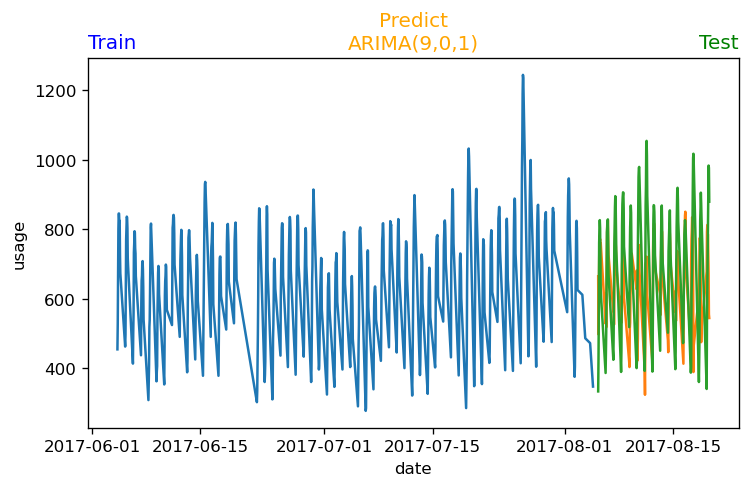

In [55]:
best_pq_finder(M9_train,M9_test)